In [230]:

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, LSTM, Embedding
from tensorflow.keras.optimizers import RMSprop

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Function definition

In [231]:
#Funcion para ver la cantidad de valores nulos por columna
def count_null_incol(df,col):
    null_values = df[col].isnull().sum()
    print(f"Total null values in column {col}: {null_values}")
    return null_values 

In [232]:
 def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [233]:
def multivariate_data(dataset
                      , target
                      , start_index # tipicaly 0 for train and "train_end_index" for test
                      , end_index # tipicaly "none" for test
                      , history_size # past observations to be considered 
                      , target_size # future observations associated to history
                      , step # gap data (explanation below)
                      , single_step=False): # whether to predict a single or multiple points
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            # label = a data point
            labels.append(target[i+target_size])
        else:
            # label = a sequence
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [234]:

#This function is used to merge the information of the weather with the data of the buildings   
def merge_weather(data, df_weather):
    df = data.merge(df_weather , left_index=True, right_index=True, how='left') 
    return df

def f_scaler(df):
    scalers = {}
    df_scaled = pd.DataFrame()
    for column in df.columns:
        scaler = MinMaxScaler()
        column_scaled = scaler.fit_transform(df[[column]])
        df_scaled[column] = column_scaled.flatten()
        scalers[column] = scaler
        
    return scalers, df_scaled



def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
def plot_predictions(y_test, y_pred, zoom_in=False, zoom_start=None, zoom_end=None):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title('Electricity Demand Prediction')
    plt.xlabel('Time (hours)')
    plt.ylabel('Electricity Demand (MW)')
    plt.legend()
    
    if zoom_in:
        plt.xlim(zoom_start, zoom_end)
    
    plt.show()

In [235]:
# The function calculates the representativity of outliers in a given column of a dataset Outliers are data points that significantly deviate 
# from the majority of the data. The representativity of outliers is a measure of how much these extreme values contribute to the overall 
# dataset.

def calculate_outlier_representativity(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1

    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    outliers_count = len(column[(column < lower_limit) | (column > upper_limit)])

    outliers_representativity = outliers_count / len(column) * 100

    return outliers_representativity

In [236]:
# Generate a line plot for the variable of interest

def plotsb(data, var):
    # Create subplots for scatter plot and box plot
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    fig.subplots_adjust(hspace=1.5)
    
    # Scatter plot
    ax1.scatter(data[var], data['electricity'])
    ax1.set_xlabel(var)
    ax1.set_ylabel('Energy Consumption')
    ax1.set_title('Scatter Plot: Energy Consumption vs {}'.format(var))

    # Box plot
    ax2.boxplot(data[var].dropna())
    ax2.set_ylabel('Electricity')
    ax2.set_title('Box Plot: {}'.format(var))

    # Display the subplots
    plt.show()

In [237]:
 def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Create Dataset

## Weather data

In [238]:
df_weather = pd.read_csv('weather.csv')

df_weather_bobcat = df_weather[df_weather['site_id'] == 'Bobcat']

df_weather_bobcat.set_index('timestamp', inplace=True, drop=True)

df_weather_bobcat = df_weather_bobcat.drop(['site_id', 'precipDepth6HR'], axis=1)

df_weather_bobcat.info()


<class 'pandas.core.frame.DataFrame'>
Index: 17525 entries, 2016-01-01 00:00:00 to 2017-12-31 23:00:00
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   airTemperature  17494 non-null  float64
 1   cloudCoverage   12595 non-null  float64
 2   dewTemperature  17491 non-null  float64
 3   precipDepth1HR  17483 non-null  float64
 4   seaLvlPressure  17274 non-null  float64
 5   windDirection   16475 non-null  float64
 6   windSpeed       17379 non-null  float64
dtypes: float64(7)
memory usage: 1.1+ MB


In [239]:
#This dataframe has missing information that is not desplayed as nulls but as rows that dont exist at all and must be considered for the time series 
# so we will create an empty dataframe with all the timestamps and then merge it with the weather dataframe to fill the missing values

start_date = '2016-01-01 00:00:00'
end_date = '2017-12-31 23:00:00'
interval = '1H'

index = pd.date_range(start=start_date, end=end_date, freq=interval) # Created a Index Dtype Timestamp
df_time = pd.DataFrame(index=index)

df_time.index = pd.to_datetime(df_time.index)
df_weather_bobcat.index = pd.to_datetime(df_weather_bobcat.index)

merged_df = df_time.merge(df_weather_bobcat , left_index=True, right_index=True, how='left')

df_weather_bobcat = merged_df.copy()

null_values = []
for col in df_weather_bobcat.columns:    
    null_values.append(count_null_incol(df_weather_bobcat, col))

Total null values in column airTemperature: 50
Total null values in column cloudCoverage: 4949
Total null values in column dewTemperature: 53
Total null values in column precipDepth1HR: 61
Total null values in column seaLvlPressure: 270
Total null values in column windDirection: 1069
Total null values in column windSpeed: 165


## Building data

In [240]:
# Import all the dataframes about the sensor's buldings 
df_gas = pd.read_csv('gas_cleaned.csv')
df_hotwater = pd.read_csv('hotwater_cleaned.csv')
df_irrigation = pd.read_csv('irrigation_cleaned.csv')
df_solar = pd.read_csv('solar_cleaned.csv')
df_steam = pd.read_csv('steam_cleaned.csv')
df_water = pd.read_csv('water_cleaned.csv')
df_electricity = pd.read_csv('electricity.csv')

In [241]:
# In this section we will take the column timestamp from all the dataframes and we will convert it to datetime format and set is as the index 
# of the dataframe

df_gas['timestamp'] = pd.to_datetime(df_gas['timestamp'])
df_gas.set_index('timestamp', inplace=True, drop=True)

df_hotwater['timestamp'] = pd.to_datetime(df_hotwater['timestamp']) 
df_hotwater.set_index('timestamp', inplace=True, drop=True) 

df_irrigation['timestamp'] = pd.to_datetime(df_irrigation['timestamp'])
df_irrigation.set_index('timestamp', inplace=True, drop=True)   

df_solar['timestamp'] = pd.to_datetime(df_solar['timestamp'])       
df_solar.set_index('timestamp', inplace=True, drop=True)    

df_steam['timestamp'] = pd.to_datetime(df_steam['timestamp'])
df_steam.set_index('timestamp', inplace=True, drop=True)

df_water['timestamp'] = pd.to_datetime(df_water['timestamp'])   
df_water.set_index('timestamp', inplace=True, drop=True)    

df_electricity['timestamp'] = pd.to_datetime(df_electricity['timestamp'])
df_electricity.set_index('timestamp', inplace=True, drop=True)

In [242]:
#We create a list that contains all the dataframes
df_name_list = [df_gas, df_hotwater, df_irrigation, df_solar, df_steam, df_water, df_electricity]

In [243]:
#We will append the datasets df_solar, df_water, df_electricity into a new dataframe called df_timothy
df_timothy = pd.DataFrame()
df_timothy['solar'] = df_solar['Bobcat_other_Timothy']
df_timothy['water'] = df_water['Bobcat_other_Timothy']
df_timothy['electricity'] = df_electricity['Bobcat_other_Timothy']  


In [244]:
df_timothy.head()

,solar,water,electricity
timestamp,,,
2016-01-01 00:00:00,0.02,0.0,36.0900
2016-01-01 01:00:00,0.01,0.0,36.3800
2016-01-01 02:00:00,0.02,0.0,34.7501
2016-01-01 03:00:00,0.02,0.0,36.4700
2016-01-01 04:00:00,0.00,0.0,35.3400


## Table append

In [245]:
new_df = df_weather_bobcat.merge(df_timothy, left_index=True, right_index=True, how='left')
print(new_df.isnull().sum())

airTemperature      50
cloudCoverage     4949
dewTemperature      53
precipDepth1HR      61
seaLvlPressure     270
windDirection     1069
windSpeed          165
solar              370
water              452
electricity         25
dtype: int64


In [246]:
column_names = new_df.columns
new_df.head()

,airTemperature,cloudCoverage,dewTemperature,precipDepth1HR,seaLvlPressure,windDirection,windSpeed,solar,water,electricity
2016-01-01 00:00:00,-14.4,0.0,-16.7,0.0,1036.9,280.0,3.1,0.02,0.0,36.0900
2016-01-01 01:00:00,-13.3,0.0,-16.7,0.0,1036.0,240.0,3.1,0.01,0.0,36.3800
2016-01-01 02:00:00,-15.0,0.0,-17.8,0.0,1035.9,240.0,2.6,0.02,0.0,34.7501
2016-01-01 03:00:00,-12.8,0.0,-17.8,0.0,1035.0,310.0,2.6,0.02,0.0,36.4700
2016-01-01 04:00:00,-14.4,0.0,-18.3,0.0,1035.3,300.0,3.6,0.00,0.0,35.3400


In [247]:
imputer = KNNImputer(n_neighbors=168)
new_df_imputed_array = imputer.fit_transform(new_df)
new_df_imputed = pd.DataFrame(new_df_imputed_array, columns=new_df.columns, index=new_df.index)
print('Missing values after imputation: ',new_df_imputed.isnull().sum())

Missing values after imputation:  airTemperature    0
cloudCoverage     0
dewTemperature    0
precipDepth1HR    0
seaLvlPressure    0
windDirection     0
windSpeed         0
solar             0
water             0
electricity       0
dtype: int64


In [248]:
#We will use a knn interpolation to fill the missing values
imputer = KNNImputer(n_neighbors=168)
new_df = pd.DataFrame(imputer.fit_transform(new_df),columns = column_names, index = new_df.index)
null_count = np.sum(np.isnan(new_df))
print('Missing values after imputation: ', null_count)
df_timothy = new_df.copy()
print(df_timothy.shape)

Missing values after imputation:  airTemperature    0
cloudCoverage     0
dewTemperature    0
precipDepth1HR    0
seaLvlPressure    0
windDirection     0
windSpeed         0
solar             0
water             0
electricity       0
dtype: int64
(17544, 10)


In [249]:
df_timothy.head()

,airTemperature,cloudCoverage,dewTemperature,precipDepth1HR,seaLvlPressure,windDirection,windSpeed,solar,water,electricity
2016-01-01 00:00:00,-14.4,0.0,-16.7,0.0,1036.9,280.0,3.1,0.02,0.0,36.0900
2016-01-01 01:00:00,-13.3,0.0,-16.7,0.0,1036.0,240.0,3.1,0.01,0.0,36.3800
2016-01-01 02:00:00,-15.0,0.0,-17.8,0.0,1035.9,240.0,2.6,0.02,0.0,34.7501
2016-01-01 03:00:00,-12.8,0.0,-17.8,0.0,1035.0,310.0,2.6,0.02,0.0,36.4700
2016-01-01 04:00:00,-14.4,0.0,-18.3,0.0,1035.3,300.0,3.6,0.00,0.0,35.3400


In [250]:
#We will use the variables windSpeed and windDirection to create a new variable that will be the wind vector

wv = df_timothy.pop('windSpeed')

# Convert to radians.
wd_rad = df_timothy.pop('windDirection')*np.pi / 180

# Calculate the wind x and y components.
df_timothy['Wx'] = wv*np.cos(wd_rad)
df_timothy['Wy'] = wv*np.sin(wd_rad)

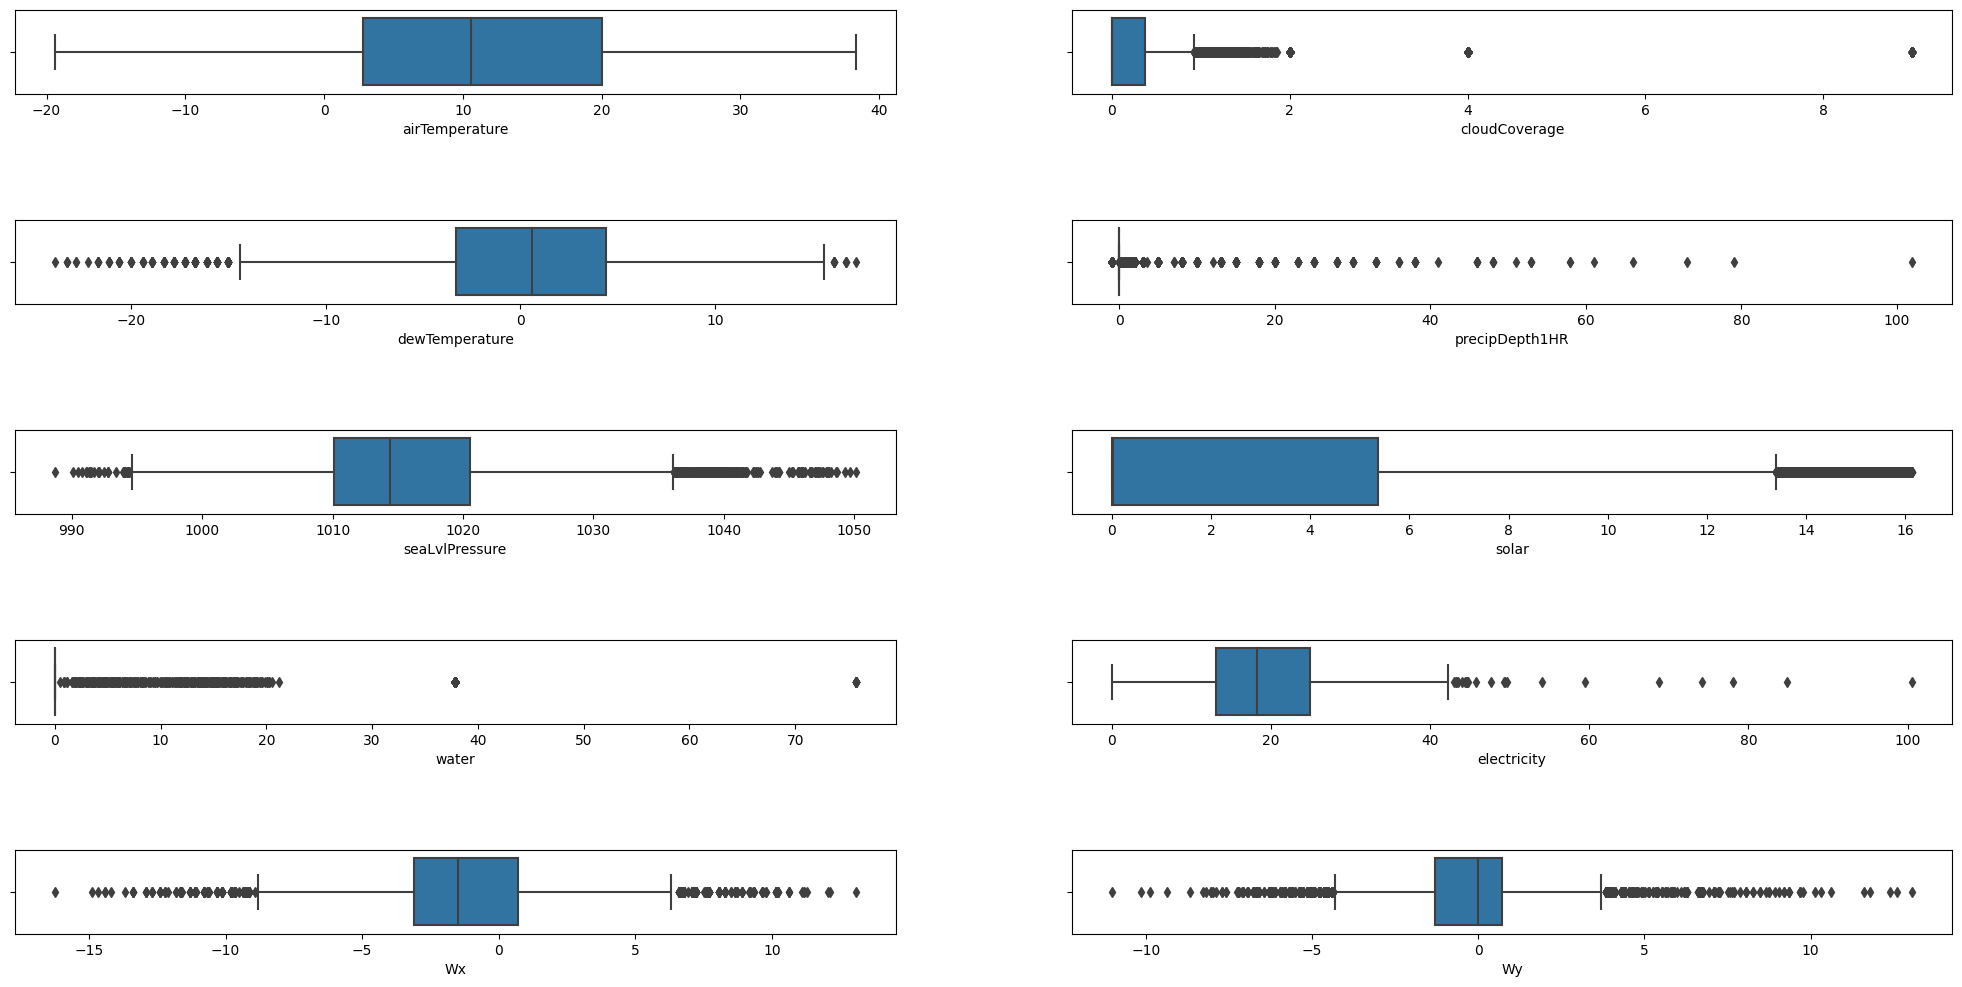

In [251]:
# Retrieve the column names from the DataFrame
var = df_timothy.columns

# Create subplots to display boxplots
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(25,12))
fig.subplots_adjust(hspace=1.5)

# Iterate over the columns and create boxplots
for i, var in enumerate(var):
    j = 0 if i%2==0 else 1
    sns.boxplot(x=var, data=df_timothy, ax=ax[i//2,j])

In [252]:
# Calculate the representativity of outliers in the column
for column in df_timothy.columns:
    representativity = calculate_outlier_representativity(df_timothy[column])
    
    # Print the representativity of outliers in the column
    print(f"The representativity of outliers in column {column} is approximately {round(representativity, 2)}%")

The representativity of outliers in column airTemperature is approximately 0.0%
The representativity of outliers in column cloudCoverage is approximately 9.62%
The representativity of outliers in column dewTemperature is approximately 1.05%
The representativity of outliers in column precipDepth1HR is approximately 10.48%
The representativity of outliers in column seaLvlPressure is approximately 2.34%
The representativity of outliers in column solar is approximately 7.26%
The representativity of outliers in column water is approximately 15.11%
The representativity of outliers in column electricity is approximately 0.13%
The representativity of outliers in column Wx is approximately 2.08%
The representativity of outliers in column Wy is approximately 3.53%


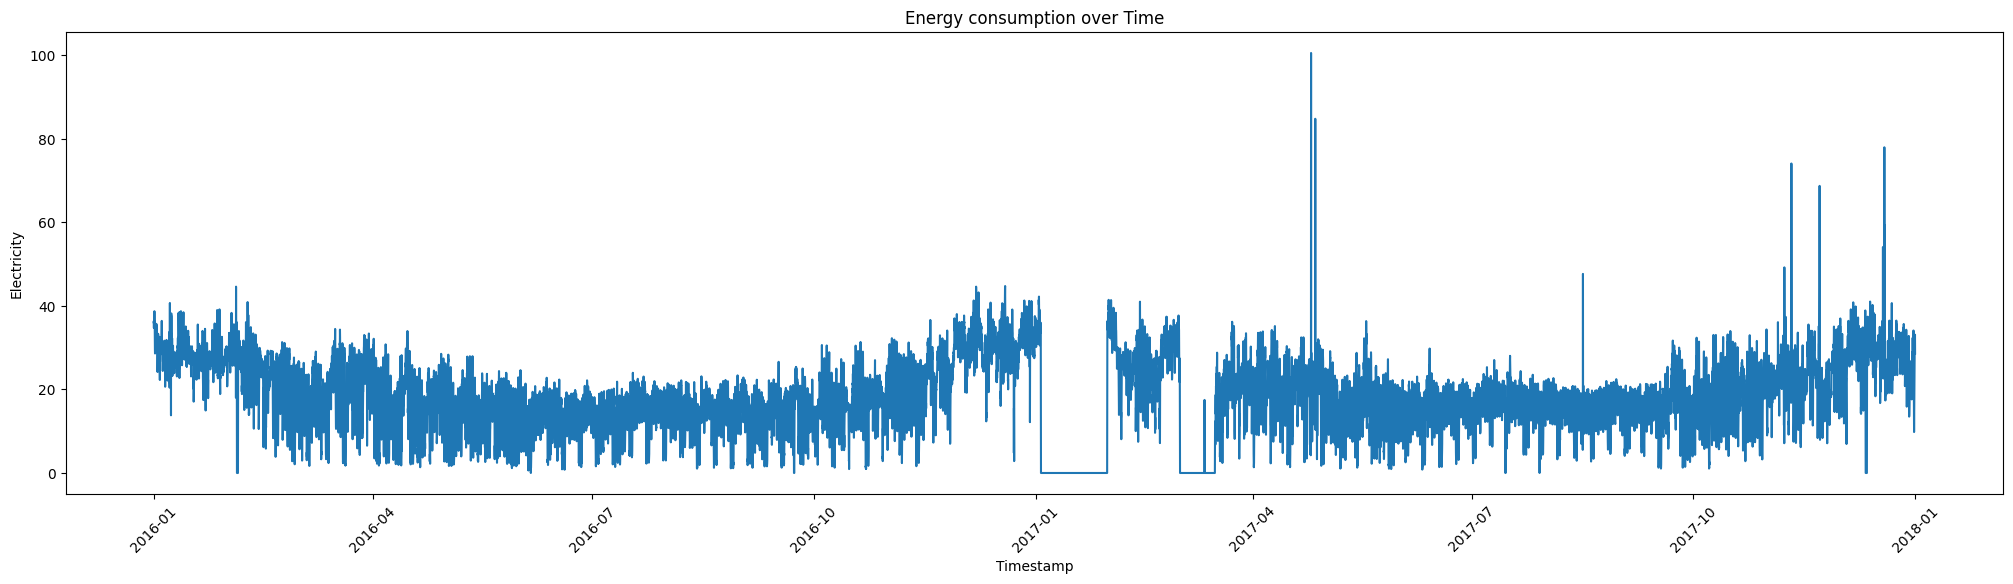

In [253]:
# Make a line plot analysis of the others Target Variable 

plt.figure(figsize=(25, 6))
plt.plot(df_timothy.index, df_timothy['electricity'])
plt.xlabel('Timestamp')
plt.ylabel('Electricity')
plt.title('Energy consumption over Time')

# Roted the x-axis for better clarity 
plt.xticks(rotation=45)

# Show the plot 
plt.show()

In [254]:
col_i = ['solar', 'water', 'airTemperature',
       'cloudCoverage', 'dewTemperature', 'precipDepth1HR', 'seaLvlPressure',
       'windDirection', 'windSpeed']

def plotsb(data, var):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    fig.subplots_adjust(hspace=1.5)
    
# Gráfico de dispersión
    ax1.scatter(data[var], data['electricity'])
    ax1.set_xlabel(var)
    ax1.set_ylabel('Energy Consumption')
    ax1.set_title('Scatter Plot: Energy Consumption vs {}'.format(var))

# Diagrama de caja
    ax2.boxplot(data[var].dropna())
    ax2.set_ylabel('Electricity')
    ax2.set_title('Box Plot: {}'.format(var))

# Mostrar los subplots
    plt.show()

In [255]:

def times(data, var): 
    # Crear la gráfica

    plt.figure(figsize=(25, 6))
    plt.plot(data.index, data[var])
    plt.xlabel('Timestamp')
    plt.ylabel(var)
    plt.title('{} over Time'.format(var))

# Rotar las etiquetas del eje x para mayor claridad (opcional)
    plt.xticks(rotation=45)

# Mostrar la gráfica
    plt.show()


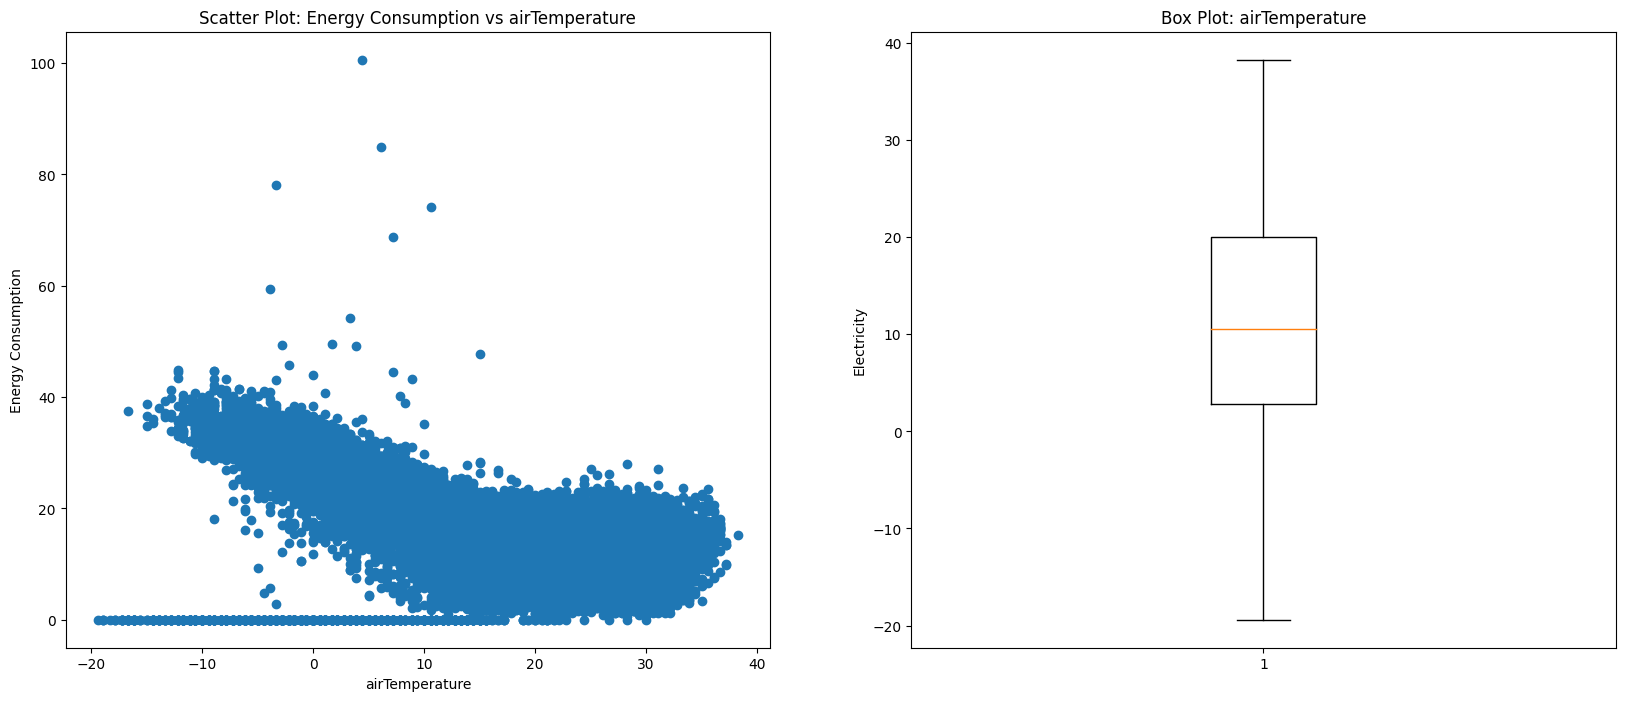

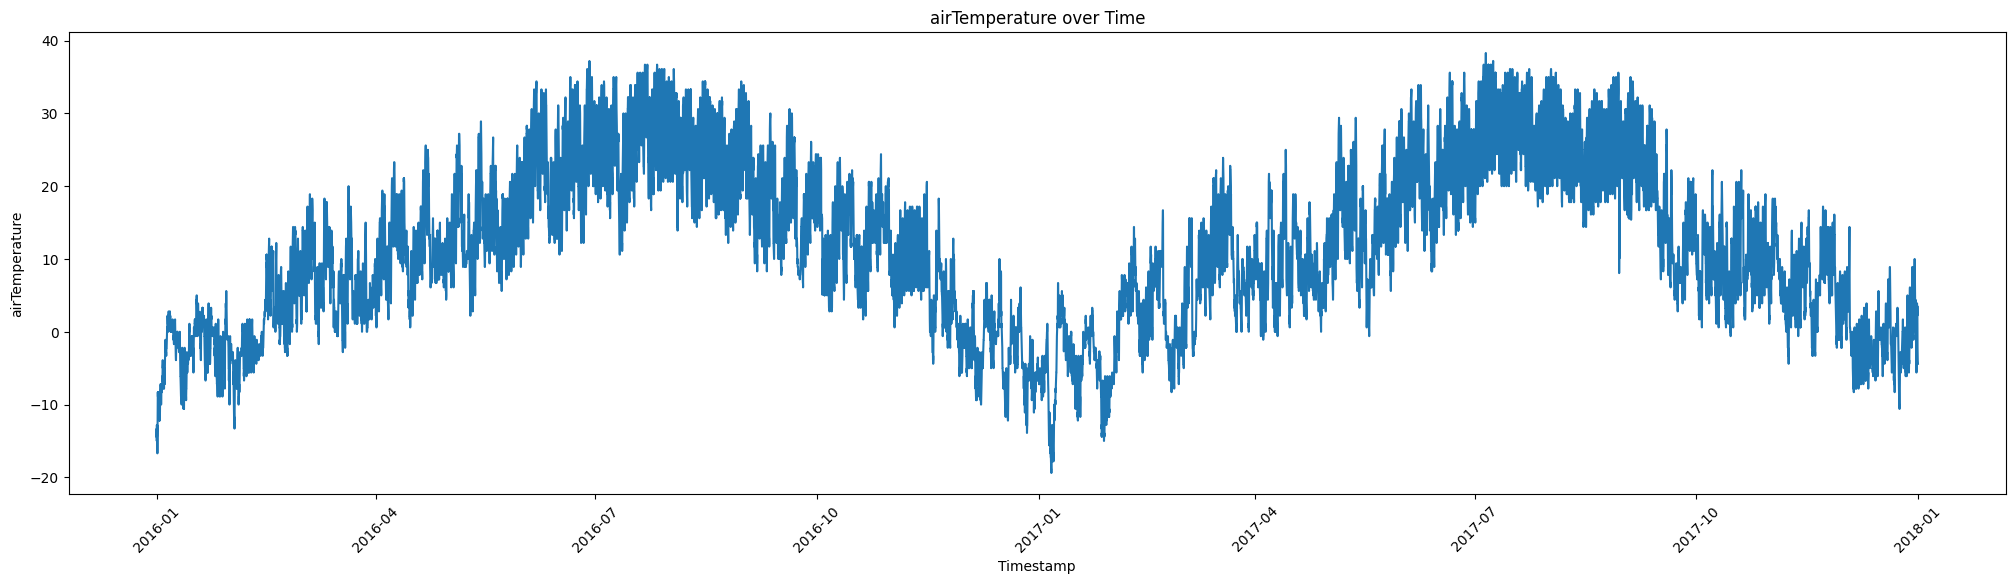

In [256]:

plotsb(df_timothy, 'airTemperature')
times(df_timothy, 'airTemperature')

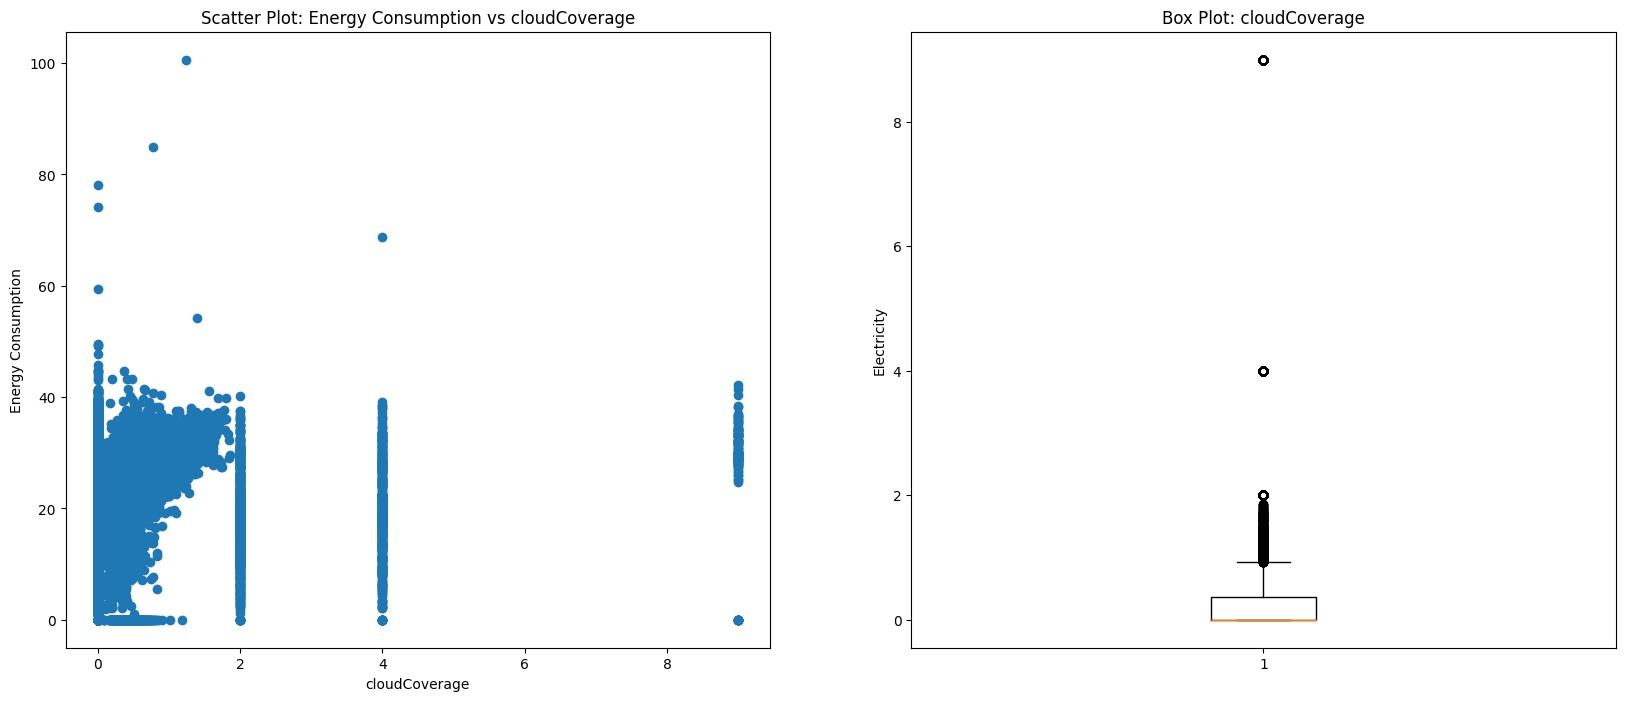

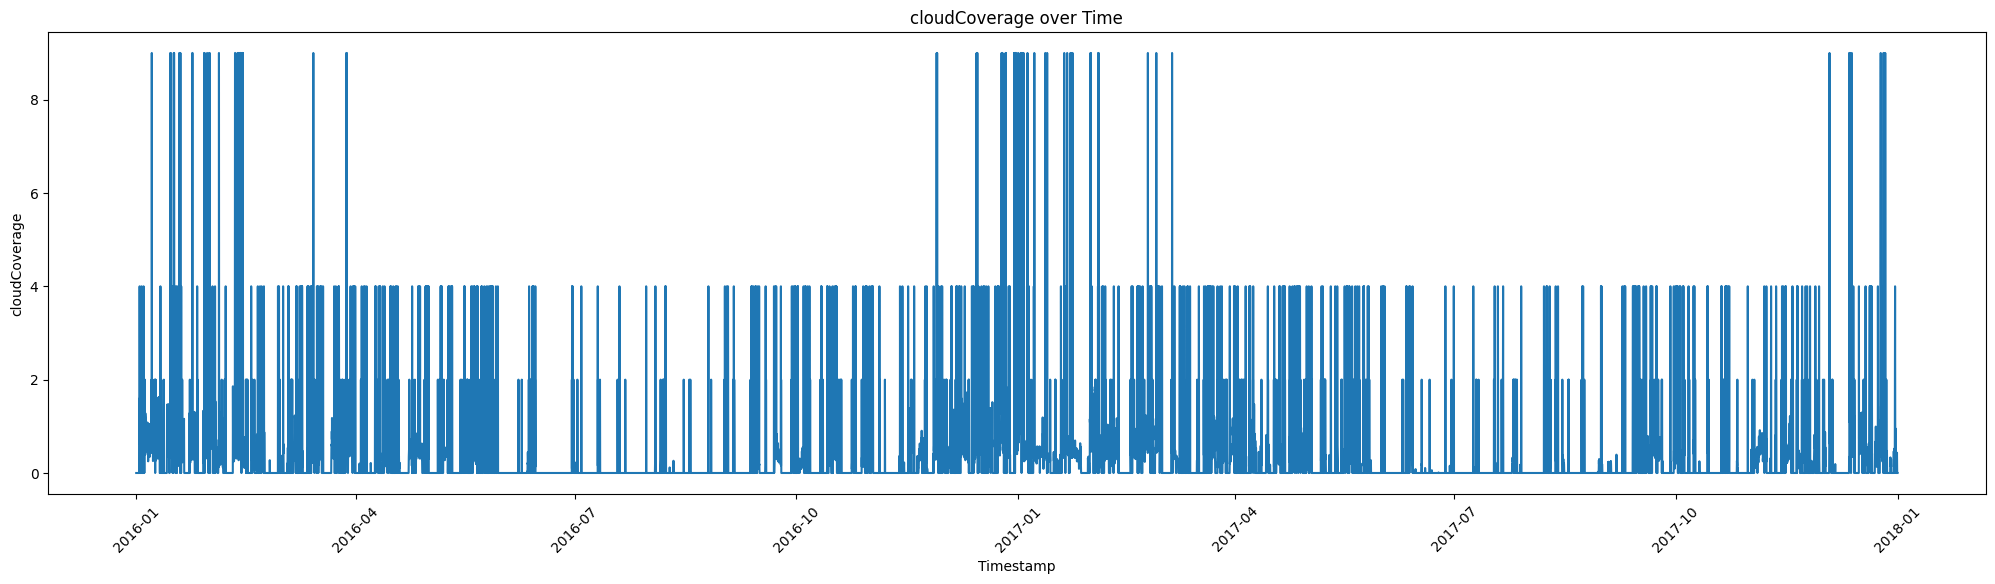

In [257]:

plotsb(df_timothy, 'cloudCoverage')
times(df_timothy, 'cloudCoverage')

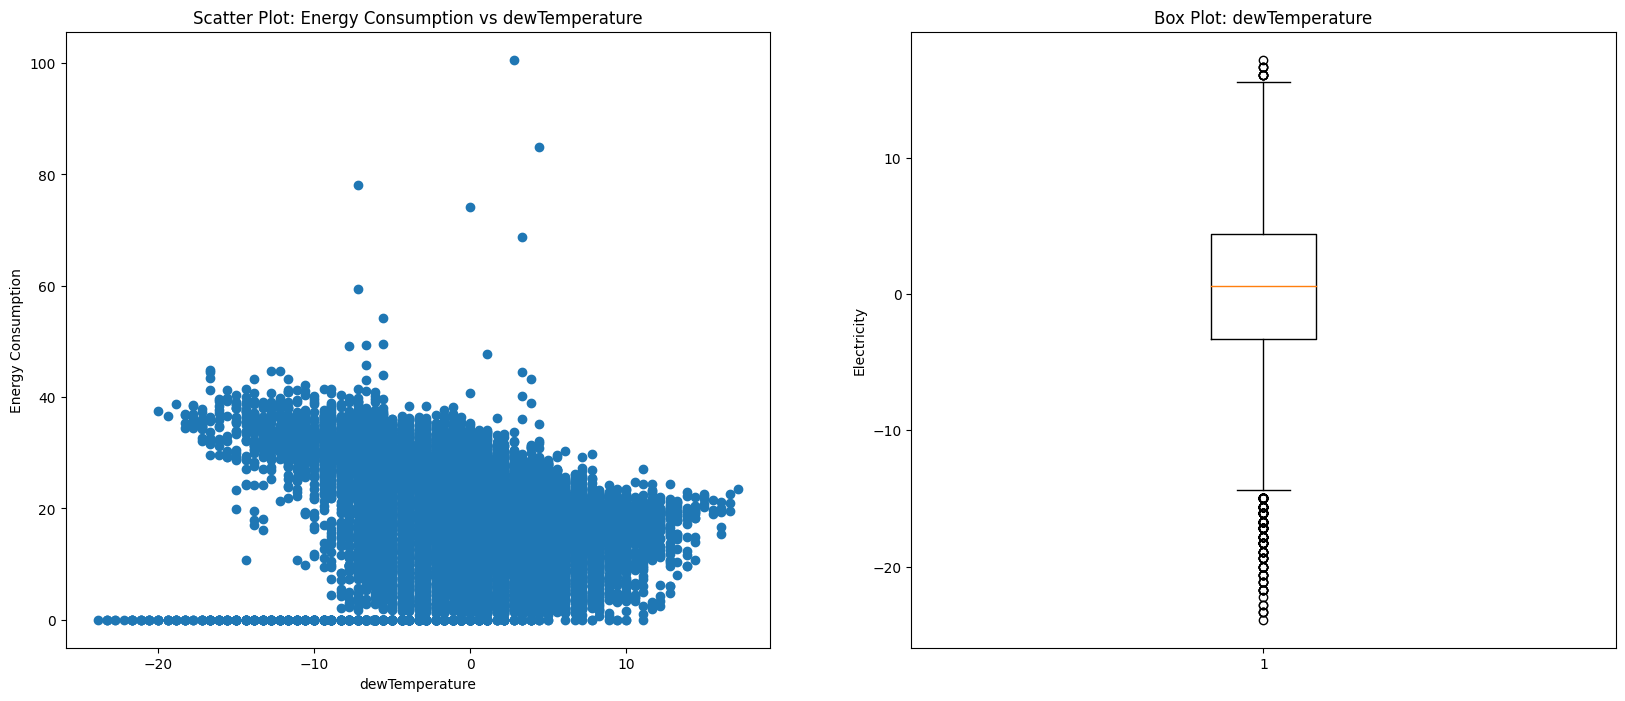

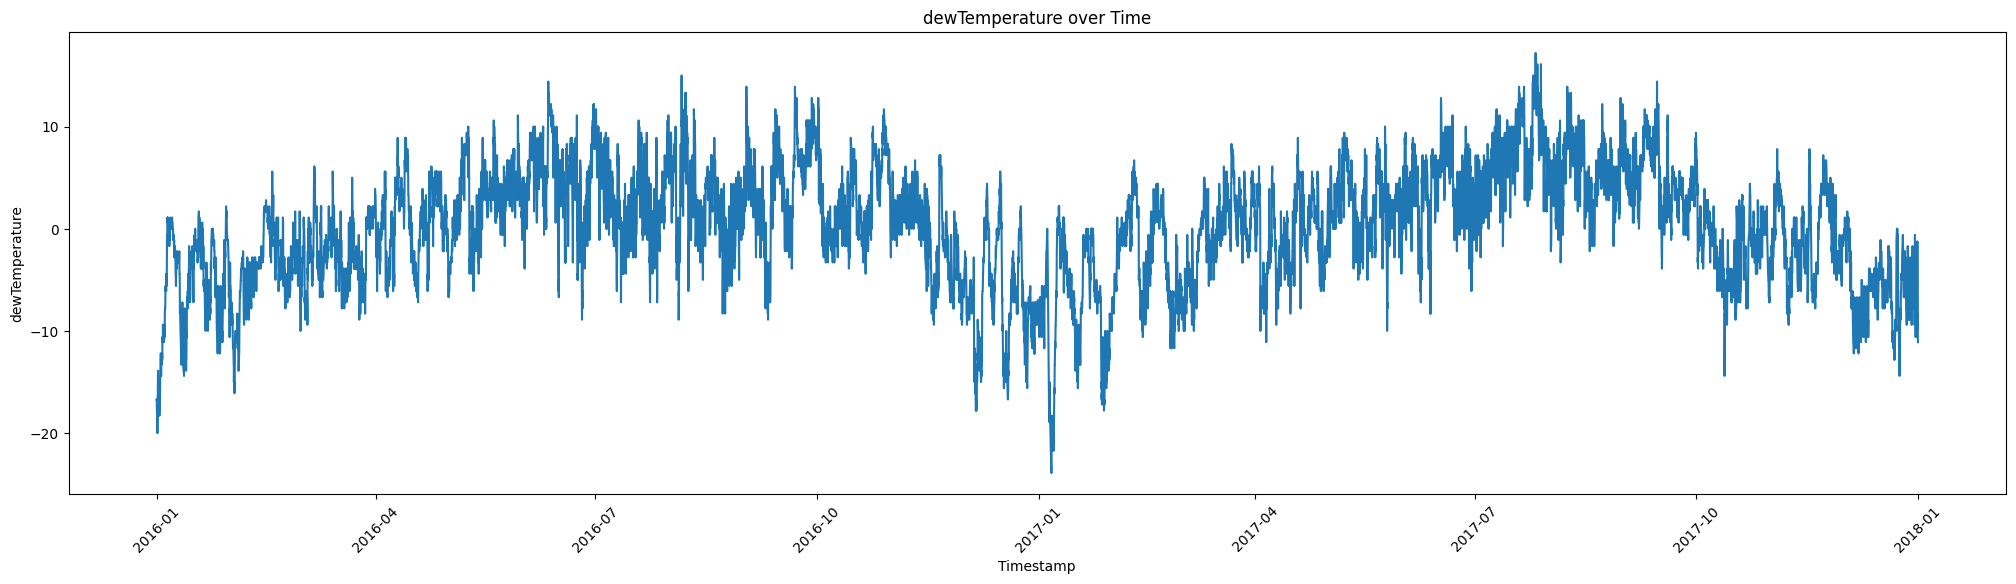

In [258]:

plotsb(df_timothy, 'dewTemperature')
times(df_timothy, 'dewTemperature')

In [259]:
### Analsis de Varianza 

def covdata(datos, var): 
    # Cargar los datos de la serie temporal en un DataFrame de Pandas
    data = datos[var]
    
    # Calcular la media de la serie
    means = float(data.mean())

# Calcular la desviación estándar de la serie
    std = float(data.std())

# Calcular la varianza de la serie
    variance = std ** 2
    print(variance)

# Crear una figura y un eje para trazar la serie temporal
    fig, ax = plt.subplots(figsize= (15,4))

# Trazar la serie temporal y la media
    ax.plot(datos.index, data, label='Serie temporal')
    ax.axhline(means, color='r', label='Media')

# Trazar dos veces la desviación estándar por encima y por debajo de la media
    ax.axhline(means + 2 * std, linestyle='--', color='g', label='2 * Desviación estándar')
    ax.axhline(means - 2 * std, linestyle='--', color='g')

# Configurar las etiquetas del eje x
    ax.tick_params(axis='x', rotation=45)

# Agregar leyenda y título
    ax.legend()
    ax.set_title('Serie temporal {} con media y dos veces la desviación estándar'.format(var))

    plt.show()

83.14197698149529


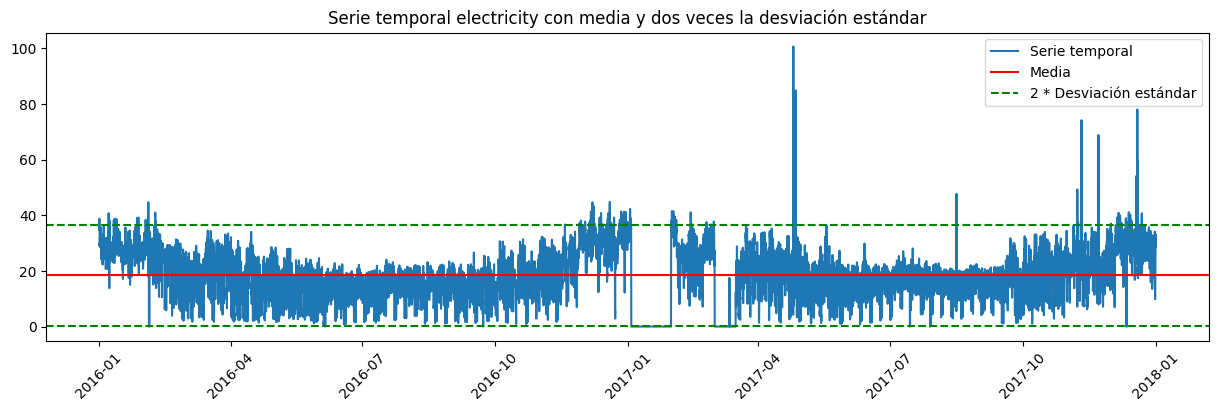

In [260]:

covdata(df_timothy, 'electricity')
# covdata(df2, 'gas')
#covdata(df2, 'hotwater')

127.43399444876079


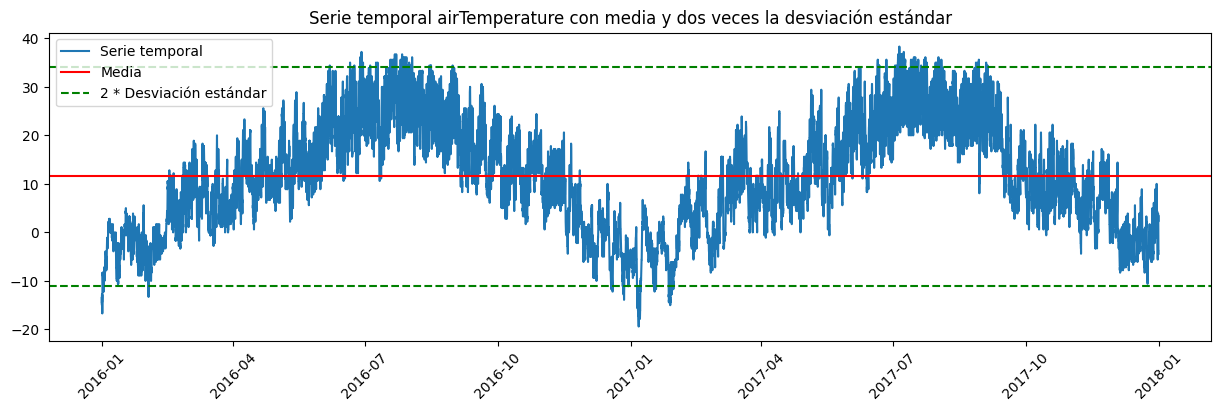

In [261]:

covdata(df_timothy, 'airTemperature')

1.1197584168275605


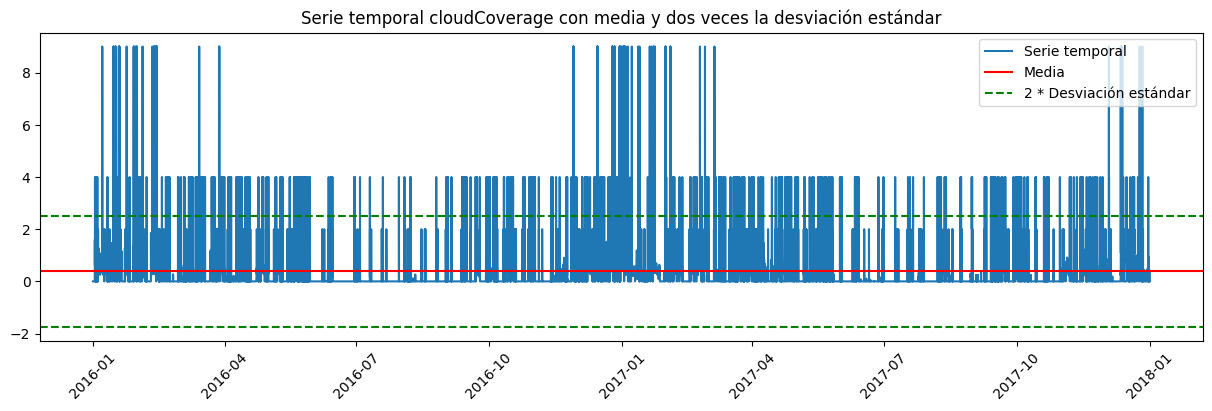

In [262]:
covdata(df_timothy, 'cloudCoverage')

32.60519752146603


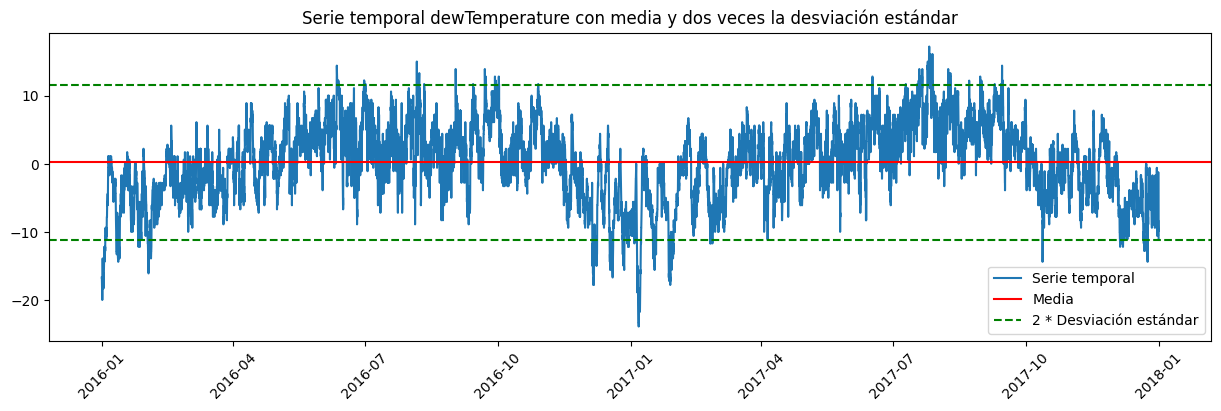

In [263]:
covdata(df_timothy, 'dewTemperature')

10.126718420712146


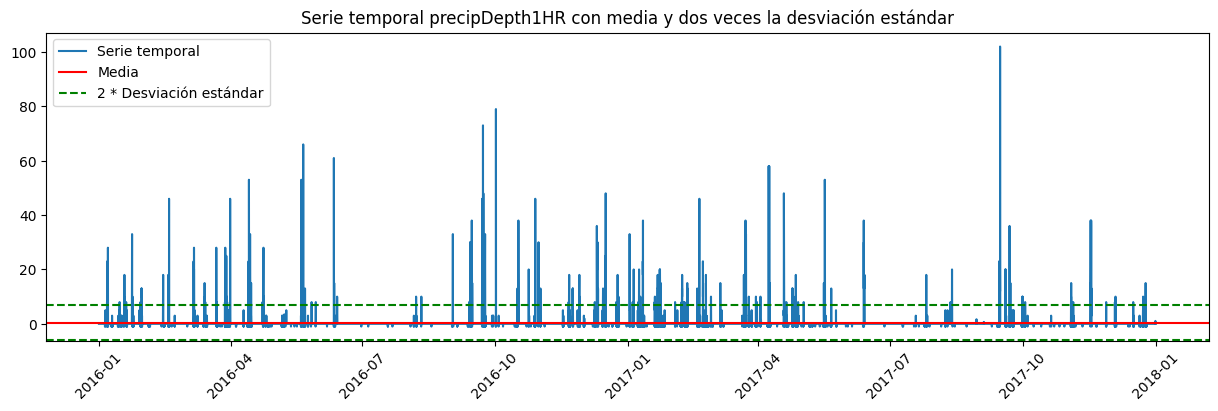

In [264]:
covdata(df_timothy, 'precipDepth1HR')

71.45928533985635


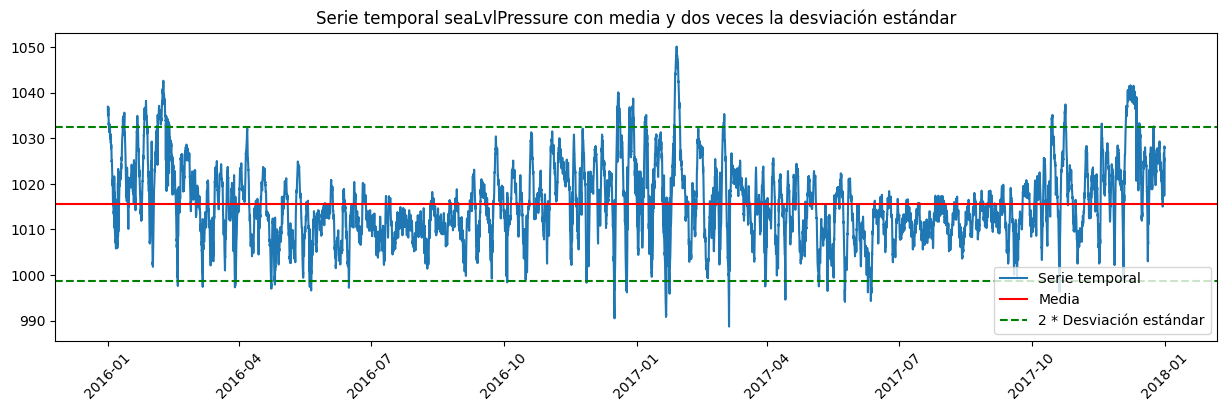

In [265]:

covdata(df_timothy, 'seaLvlPressure')

In [266]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

def desser(var, df_2, start_date, end_date):
    # Convertir las fechas a pd.Timestamp si aún no están en ese formato
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)

    # Filtrar el DataFrame para el rango de fechas deseado
    df_filtered = df_2.loc[start_date:end_date]

    # Realizar la descomposición estacional de manera aditiva en el DataFrame filtrado
    SerieDescompuesta = seasonal_decompose(df_filtered[var], model='additive')

    # Configurar el tamaño de la figura
    plt.figure(figsize=(20, 12))  # Ancho: 20 pulgadas, Alto: 12 pulgadas

    # Graficar la descomposición estacional del DataFrame filtrado
    ax = SerieDescompuesta.plot(observed=True, seasonal=True, trend=True, resid=True, weights=False)

    # Establecer las marcas de las fechas y rotarlas 45 grados
    #ax.xaxis.set_tick_params(rotation=45)

    # Mostrar el gráfico
    plt.show()

In [267]:
df_timothy.isnull().sum()

airTemperature    0
cloudCoverage     0
dewTemperature    0
precipDepth1HR    0
seaLvlPressure    0
solar             0
water             0
electricity       0
Wx                0
Wy                0
dtype: int64

In [268]:
df_timothy.columns

Index(['airTemperature', 'cloudCoverage', 'dewTemperature', 'precipDepth1HR',
       'seaLvlPressure', 'solar', 'water', 'electricity', 'Wx', 'Wy'],
      dtype='object')

In [269]:
#We will rearange the order of the columns and will place electricity in the last column
df_timothy = df_timothy[['solar', 'water', 'airTemperature', 'cloudCoverage', 'dewTemperature', 'precipDepth1HR', 'seaLvlPressure', 'Wx', 'Wy', 'electricity']]

<Figure size 2000x1200 with 0 Axes>

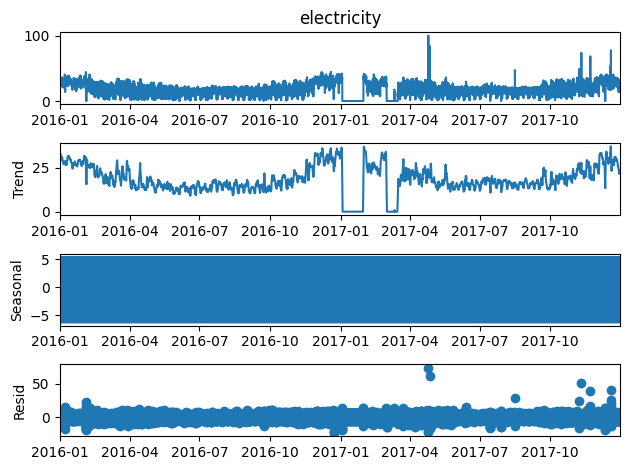

In [270]:
var = df_timothy.columns
desser('electricity', df_timothy, '2016-01-01', '2017-12-31')

<Figure size 2000x1200 with 0 Axes>

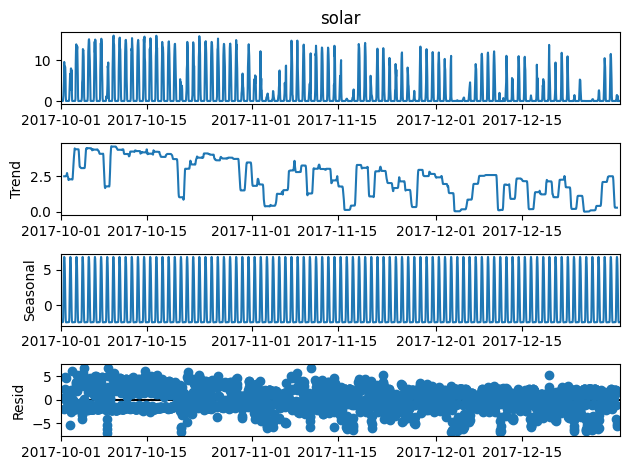

<Figure size 2000x1200 with 0 Axes>

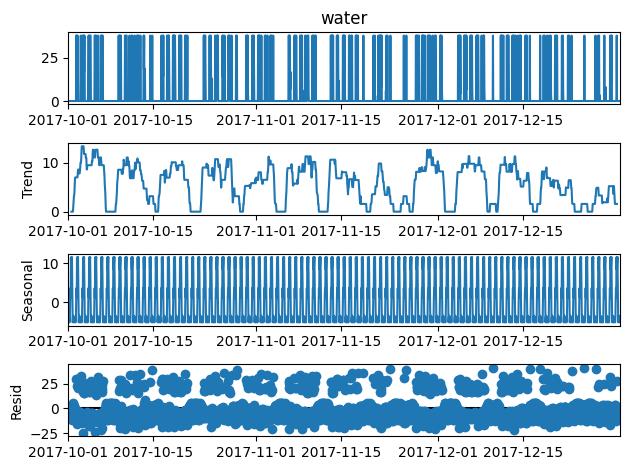

<Figure size 2000x1200 with 0 Axes>

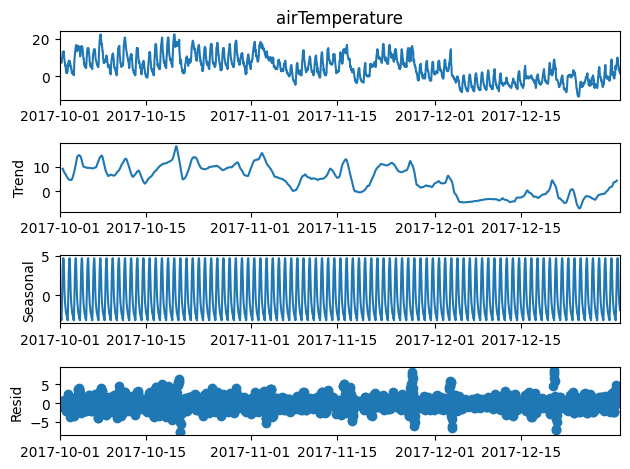

<Figure size 2000x1200 with 0 Axes>

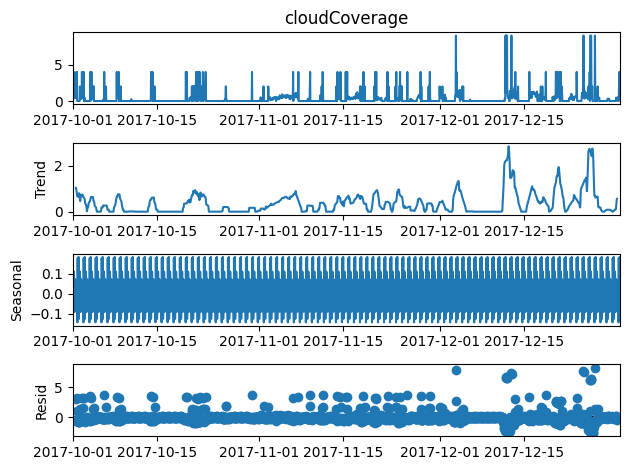

<Figure size 2000x1200 with 0 Axes>

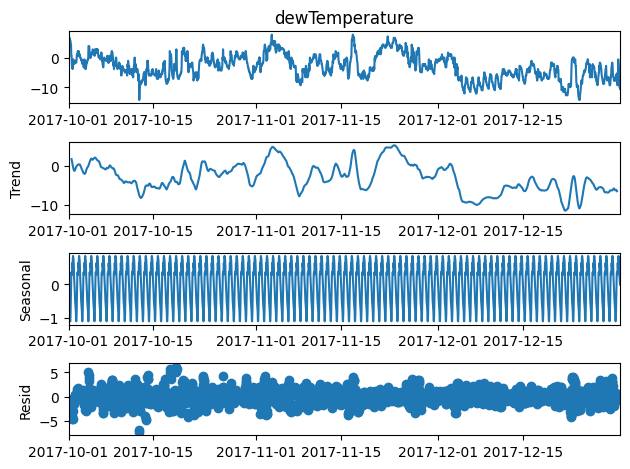

<Figure size 2000x1200 with 0 Axes>

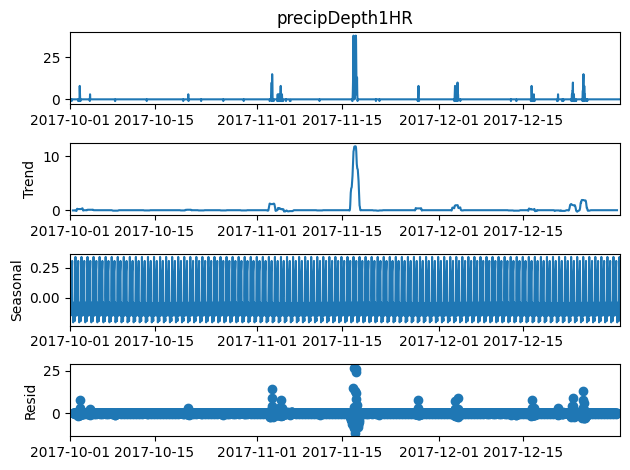

<Figure size 2000x1200 with 0 Axes>

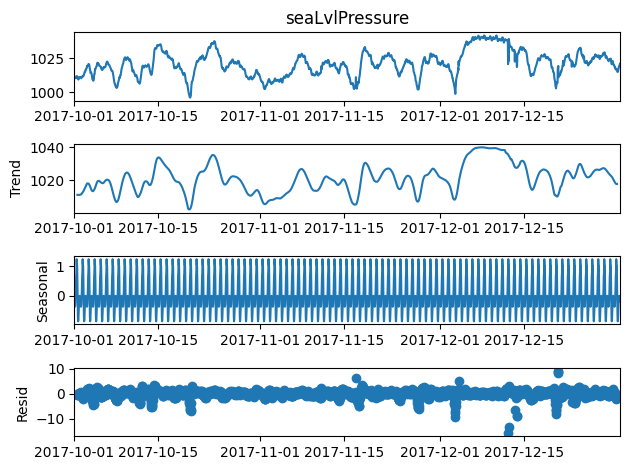

<Figure size 2000x1200 with 0 Axes>

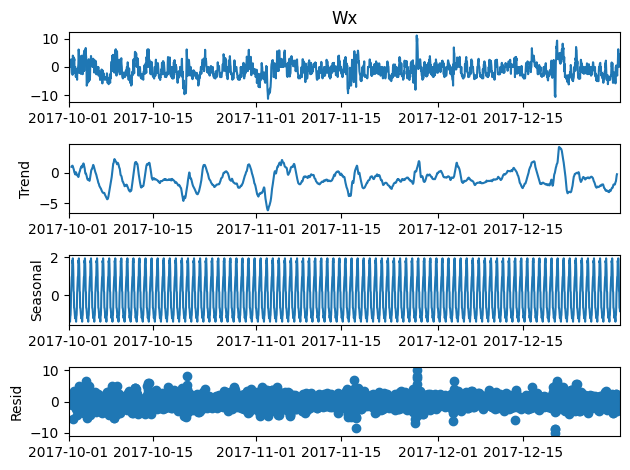

<Figure size 2000x1200 with 0 Axes>

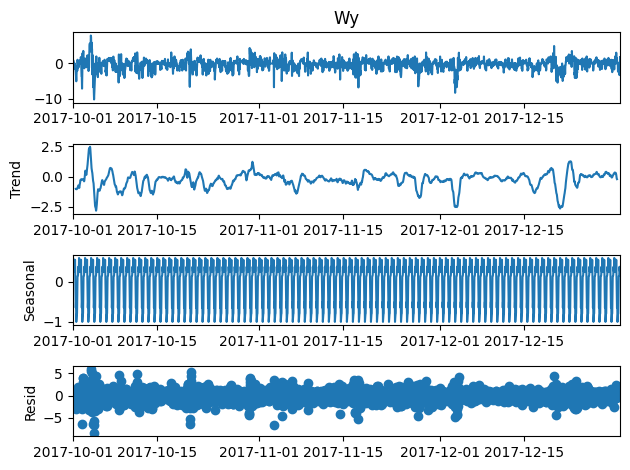

<Figure size 2000x1200 with 0 Axes>

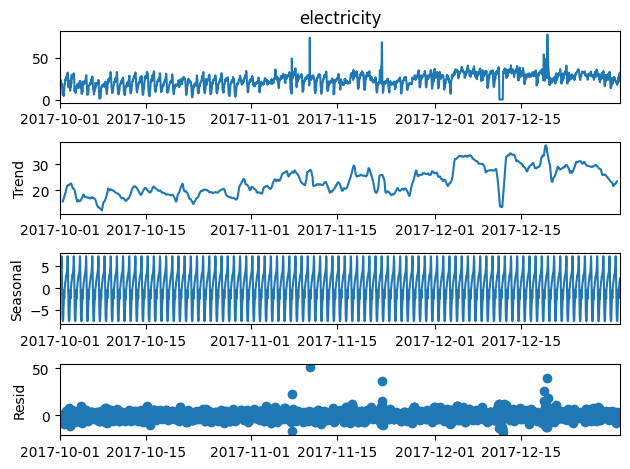

In [271]:
for i in df_timothy.columns:
    desser(i,df_timothy, '2017-10-01', '2017-12-31')

# LSTM NN data preparation

In [272]:
#Dataset split
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df_timothy, shuffle = False)

In [273]:
scaler, df_timothy_scaled = f_scaler(df_timothy)


In [274]:
train_data.tail()

,solar,water,airTemperature,cloudCoverage,dewTemperature,precipDepth1HR,seaLvlPressure,Wx,Wy,electricity
2017-07-02 01:00:00,0.02,0.0,21.7,0.0,4.4,0.0,1008.3,-2.560500,-0.451485,17.13
2017-07-02 02:00:00,0.01,0.0,21.1,0.0,4.4,0.0,1008.2,-4.037712,0.711958,17.69
2017-07-02 03:00:00,0.01,0.0,20.0,0.0,3.9,0.0,1007.7,-2.443201,-0.889252,16.84
2017-07-02 04:00:00,0.01,0.0,21.7,0.0,5.0,0.0,1008.0,1.992642,2.374738,17.25
2017-07-02 05:00:00,0.00,0.0,18.9,0.0,4.4,0.0,1008.9,-0.964181,-1.149067,17.13


In [275]:
X = df_timothy_scaled.iloc[:, :-1].values  # Select all rows and all columns except the last one
y = df_timothy_scaled.iloc[:, -1].values

In [276]:
past_history = 24
future_target = 1
train_split = 13000
STEP = 1

X_train, y_train = multivariate_data(dataset = X
                   , target = y # first column as target variable
                   , start_index = 0 # tipicaly 0 for train and "train_end_index" for test
                   , end_index = train_split # tipicaly "none" for test
                   , history_size = past_history # past observations to be considered
                   , target_size = future_target # future observations associated to history
                   , step = STEP
                   , single_step = True) # whether to predict a single or multiple points
 

In [277]:
past_history = 24
future_target = 1
train_split = 13000
STEP = 1


X_test, y_test = multivariate_data(dataset = X
                   , target = y # first column as target variable
                   , start_index = train_split # tipicaly 0 for train and "train_end_index" for test
                   , end_index = None # tipicaly "none" for test
                   , history_size = past_history # past observations to be considered
                   , target_size = future_target # future observations associated to history
                   , step = STEP
                   , single_step = True) # whether to predict a single or multiple points


In [278]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(12976, 24, 9)
(12976,)
(4519, 24, 9)
(4519,)


# NN Models

In [279]:
import tensorflow as tf

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(75, input_shape= (X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(tf.keras.layers.LSTM(50, return_sequences=False))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 24, 75)            25500     
                                                                 
 lstm_21 (LSTM)              (None, 50)                25200     
                                                                 
 dense_12 (Dense)            (None, 1)                 51        
                                                                 
Total params: 50751 (198.25 KB)
Trainable params: 50751 (198.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [280]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience= 10,
                                                  mode = 'min')

model.compile(loss=tf.losses.MeanSquaredError(), 
              optimizer=tf.optimizers.Adam(), 
              metrics=[tf.metrics.MeanAbsoluteError()])


history = model.fit(X_train, y_train, epochs= 50,
                              validation_data= (X_test, y_test),
                              shuffle= False,
                              callbacks = [early_stopping])

Epoch 1/50


406/406 [==============================] - 8s 14ms/step - loss: 0.0077 - mean_absolute_error: 0.0589 - val_loss: 0.0092 - val_mean_absolute_error: 0.0700
Epoch 2/50
406/406 [==============================] - 5s 12ms/step - loss: 0.0082 - mean_absolute_error: 0.0626 - val_loss: 0.0063 - val_mean_absolute_error: 0.0581
Epoch 3/50
406/406 [==============================] - 5s 12ms/step - loss: 0.0073 - mean_absolute_error: 0.0597 - val_loss: 0.0068 - val_mean_absolute_error: 0.0599
Epoch 4/50
406/406 [==============================] - 5s 12ms/step - loss: 0.0072 - mean_absolute_error: 0.0591 - val_loss: 0.0069 - val_mean_absolute_error: 0.0606
Epoch 5/50
406/406 [==============================] - 5s 12ms/step - loss: 0.0072 - mean_absolute_error: 0.0597 - val_loss: 0.0061 - val_mean_absolute_error: 0.0564
Epoch 6/50
406/406 [==============================] - 5s 12ms/step - loss: 0.0071 - mean_absolute_error: 0.0593 - val_loss: 0.0059 - val_mean_absolute_error: 0.0564
Epoch 7/50
406/406 [=

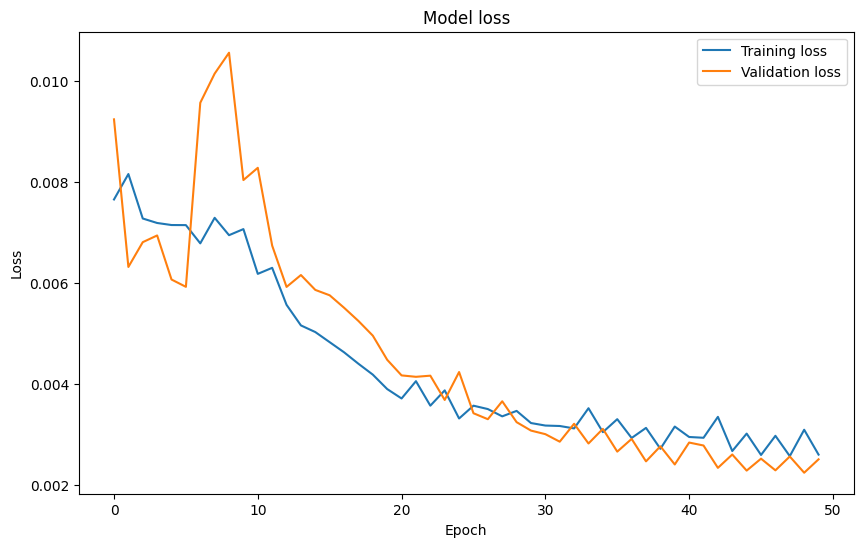

In [281]:
plot_loss(history)

4/4 [==============================] - 0s 4ms/step


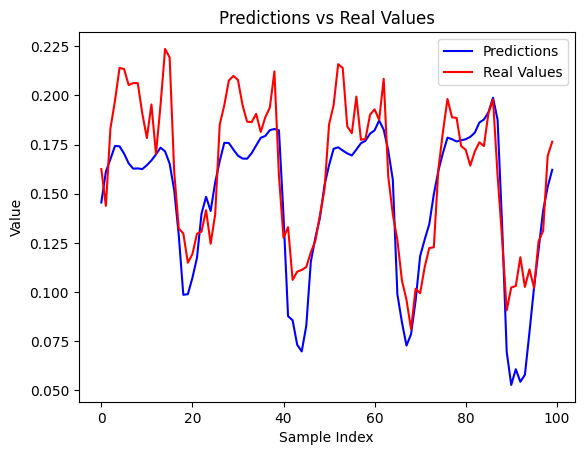

In [282]:
predictions = model.predict(X_test[:100])  # Adjust the range as needed

# Plot predictions vs real values
plt.plot(range(100), predictions, 'b', label='Predictions')
plt.plot(range(100), y_test[:100], 'r', label='Real Values')
plt.title('Predictions vs Real Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 24, 64)            18944     
                                                                 
 lstm_23 (LSTM)              (None, 64)                33024     
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 52033 (203.25 KB)
Trainable params: 52033 (203.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
406/406 [==============================] - 8s 13ms/step - loss: 0.0076 - mean_absolute_error: 0.0604 - val_loss: 0.0084 - val_mean_absolute_error: 0.0667
Epoch 2/50
406/406 [==============================] - 5s 12ms/step - loss: 0.0081 - mean_absolute_error: 0.0623 - 

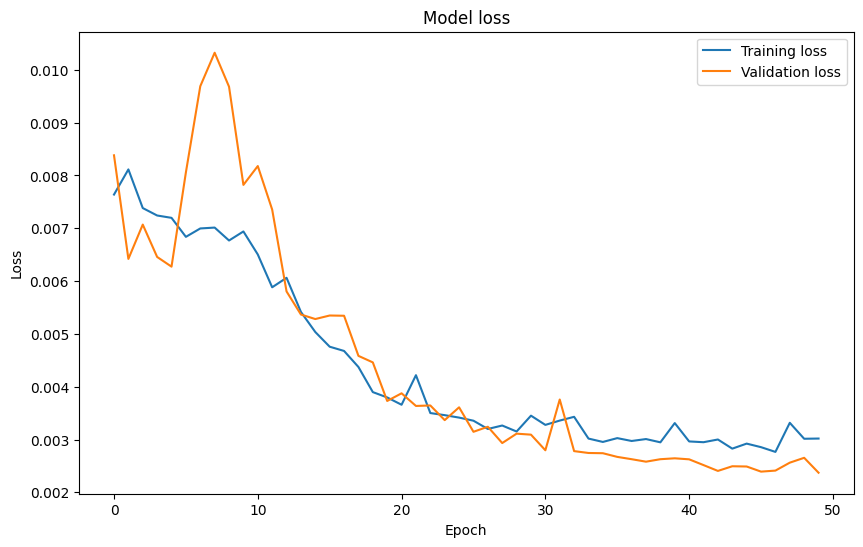

In [283]:
model2 = tf.keras.Sequential()

model2.add(tf.keras.layers.LSTM(64, input_shape= (X_train.shape[1], X_train.shape[2]), return_sequences=True))
model2.add(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=False))
model2.add(tf.keras.layers.Dense(1))

model2.summary()

model2.compile(loss=tf.losses.MeanSquaredError(), 
              optimizer=tf.optimizers.Adam(), 
              metrics=[tf.metrics.MeanAbsoluteError()])


history2 = model2.fit(X_train, y_train, epochs= 50,
                              validation_data= (X_test, y_test),
                              shuffle= False,
                              callbacks = [early_stopping])

plot_loss(history2)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 128)               37888     
 onal)                                                           
                                                                 
 dense_14 (Dense)            (None, 1)                 129       
                                                                 
Total params: 38017 (148.50 KB)
Trainable params: 38017 (148.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
406/406 [==============================] - 5s 8ms/step - loss: 0.0077 - mean_absolute_error: 0.0598 - val_loss: 0.0062 - val_mean_absolute_error: 0.0573
Epoch 2/50
406/406 [==============================] - 3s 7ms/step - loss: 0.0080 - mean_absolute_error: 0.0568 - val_loss: 0.0046 - val_mean_absolute_error: 0.0491
Epoch 3/50
406/40

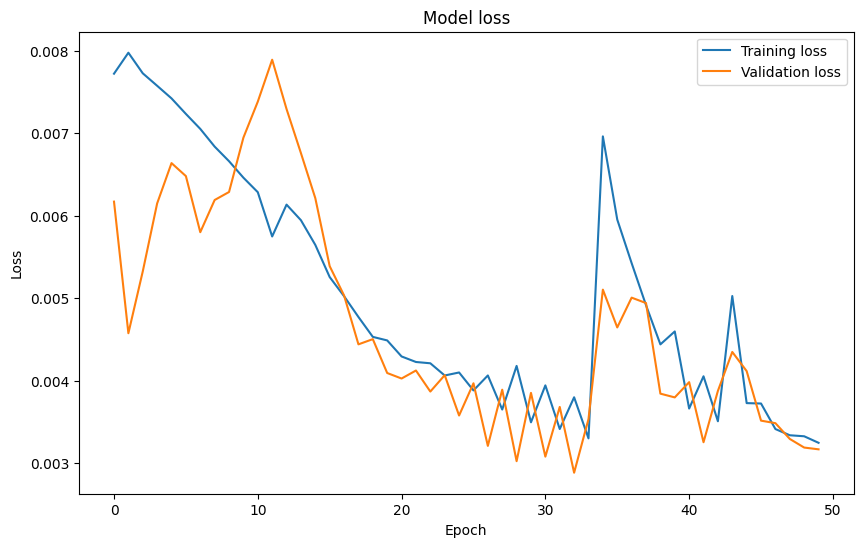

In [284]:
from keras.layers import LSTM, Dense, Bidirectional

model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh'), input_shape=(X_train.shape[1], X_train.shape[2])))
model3.add(tf.keras.layers.Dense(1, activation='linear'))

model3.summary()

model3.compile(loss=tf.losses.MeanSquaredError(), 
              optimizer=tf.optimizers.Adam(), 
              metrics=[tf.metrics.MeanAbsoluteError()])


history3 = model3.fit(X_train, y_train, epochs= 50,
                              validation_data= (X_test, y_test),
                              shuffle= False)

plot_loss(history3) # Del tiempo de periodo que se esta entrenado y el tiempo del tiempo valido 

In [285]:
%pip install keras-attention

Note: you may need to restart the kernel to use updated packages.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 24, 9)]              0         []                            
                                                                                                  
 lstm_25 (LSTM)              (None, 24, 128)              70656     ['input_2[0][0]']             
                                                                                                  
 lstm_26 (LSTM)              (None, 64)                   49408     ['lstm_25[0][0]']             
                                                                                                  
 attention_1 (Attention)     (None, 64)                   0         ['lstm_26[0][0]',             
                                                                     'lstm_26[0][0]']       

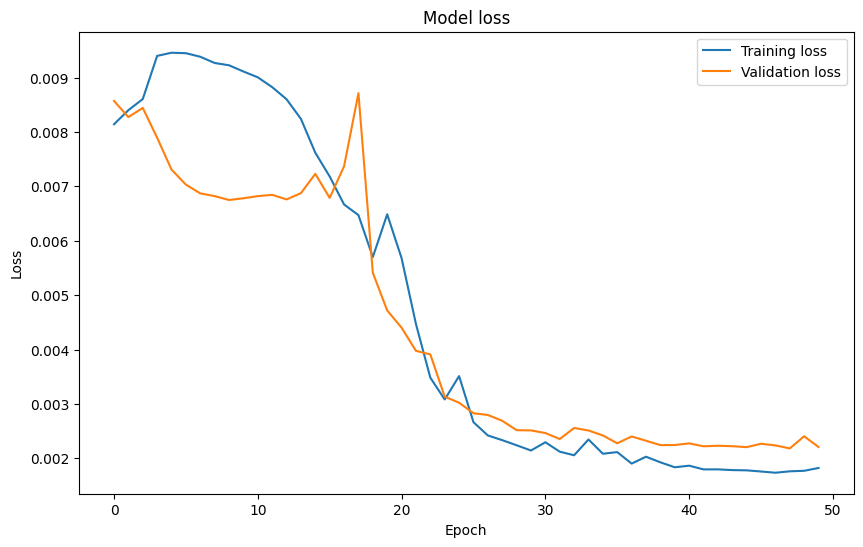

In [286]:
from keras.layers import Attention

inputs = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm_output_1 = tf.keras.layers.LSTM(128, return_sequences=True)(inputs)
lstm_output_2 = tf.keras.layers.LSTM(64, return_sequences=False)(lstm_output_1)
attention = Attention()([lstm_output_2, lstm_output_2])
output = tf.keras.layers.Dense(1, activation='linear')(attention)
model4 = tf.keras.Model(inputs=inputs, outputs=output)

model4.summary()

model4.compile(loss=tf.losses.MeanSquaredError(), 
              optimizer=tf.optimizers.Adam(), 
              metrics=[tf.metrics.MeanAbsoluteError()])


history4 = model4.fit(X_train, y_train, epochs= 50,
                              validation_data= (X_test, y_test),
                              shuffle= False,
                              callbacks = [early_stopping])

plot_loss(history4)

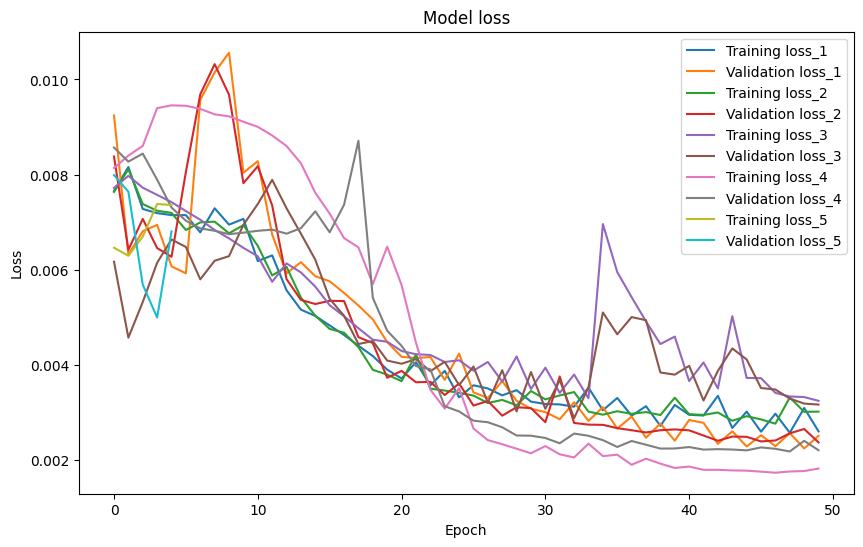

In [287]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training loss_1')
plt.plot(history.history['val_loss'], label='Validation loss_1')
plt.plot(history2.history['loss'], label='Training loss_2')
plt.plot(history2.history['val_loss'], label='Validation loss_2')
plt.plot(history3.history['loss'], label='Training loss_3')
plt.plot(history3.history['val_loss'], label='Validation loss_3')
plt.plot(history4.history['loss'], label='Training loss_4')
plt.plot(history4.history['val_loss'], label='Validation loss_4')
plt.plot(history5.history['loss'], label='Training loss_5')
plt.plot(history5.history['val_loss'], label='Validation loss_5')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

4/4 [==============================] - 1s 19ms/step


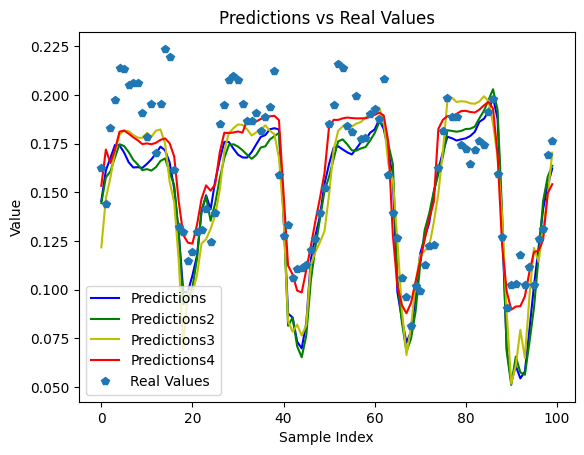

In [288]:
predictions1 = model.predict(X_test[:100])  # Adjust the range as needed
predictions2 = model2.predict(X_test[:100])
predictions3 = model3.predict(X_test[:100])
predictions4 = model4.predict(X_test[:100])
predictions5 = model5.predict(X_test[:100])

# Plot predictions vs real values
plt.plot(range(100), predictions, 'b', label='Predictions')
plt.plot(range(100), predictions2, 'g', label='Predictions2')
plt.plot(range(100), predictions3, 'y', label='Predictions3')
plt.plot(range(100), predictions4, 'r', label='Predictions4')
plt.plot(range(100), y_test[:100], 'p', label='Real Values')
plt.title('Predictions vs Real Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

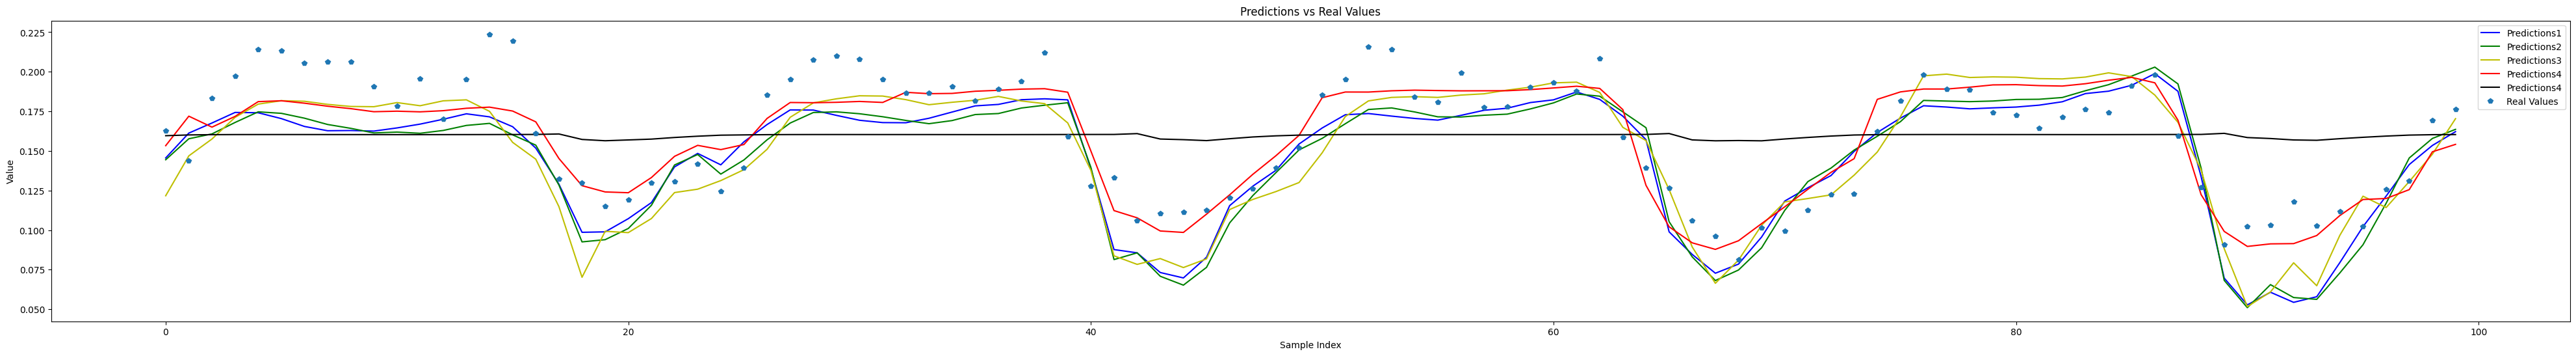

In [289]:
# Plot predictions vs real values
plt.figure(figsize=(50, 6))  # Set the width and height of the plot

plt.plot(range(100), predictions1, 'b', label='Predictions1')
plt.plot(range(100), predictions2, 'g', label='Predictions2')
plt.plot(range(100), predictions3, 'y', label='Predictions3')
plt.plot(range(100), predictions4, 'r', label='Predictions4')
plt.plot(range(100), predictions5, '#000000', label='Predictions4')
plt.plot(range(100), y_test[:100], 'p', label='Real Values')
plt.title('Predictions vs Real Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [292]:
from sklearn.metrics import mean_absolute_error

predictions1 = model.predict(X_test)  # Adjust the range as needed
predictions2 = model2.predict(X_test)
predictions3 = model3.predict(X_test)
predictions4 = model4.predict(X_test)
predictions5 = model4.predict(X_test)


mae1 = mean_absolute_error(y_test, predictions1)
mae2 = mean_absolute_error(y_test, predictions2)
mae3 = mean_absolute_error(y_test, predictions3)
mae4 = mean_absolute_error(y_test, predictions4)
mae5 = mean_absolute_error(y_test, predictions5)

  1/142 [..............................] - ETA: 3s

142/142 [==============================] - 1s 8ms/step


In [293]:
print(mae1)
print(mae2)
print(mae3)
print(mae4)
print(mae5)

0.03213825162885223
0.03196261755339028
0.038517340329131934
0.03203777947199165
0.03203777947199165
